In [121]:
from landmark_detection.preprocess import PreprocessModule
from ultralytics import YOLO
from landmark_detection.extract import CVNet_SG
from landmark_detection.postprocess import PostprocessModule
from landmark_detection.search import Similarity_Search
from landmark_detection.utils import show_image, show_bboxes, show_similarity_search
from landmark_detection.pipeline import Pipeline_Landmark_Detection

import os
import pandas as pd
import cv2
import torch
import onnxruntime as ort

In [122]:
VERSION = 5

# DATABASE
force_rebuild = False
save_every = 500
min_area = 0.05
min_sim_db = 0.7

# PIPELINE
detector_file = "yolov8n-oiv7.pt"
extractor_onnx_file = "cvnet-sg-v" + str(VERSION) + ".onnx"
pipeline_onnx_file = "pipeline-yolo-cvnet-sg-v" + str(VERSION) + ".onnx"
image_dim = (640, 640)
allowed_classes = [41,68,70,74,87,95,113,144,150,158,164,165,193,205,212,224,257,
                              298,310,335,351,354,390,393,401,403,439,442,457,466,489,510,512,
                              514,524,530,531,543,546,554,565,573,580,588,591]
score_thresh = 0.05
iou_thresh = 0.25
scales = [0.7071, 1.0, 1.4142]
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
rgem_pr = 2.5
rgem_size = 5
gem_p = 4.6
sgem_ps = 10.0
sgem_infinity = False
eps = 1e-8
topk = 10
min_sim = 0.65
min_votes = 0.5
remove_inner_boxes = 0.5
join_boxes = True

In [123]:
# Dataset Cáceres
DATASETS_PATH = os.path.abspath("datasets")

CACERES_LANDMARK_NAMES_PATH = os.path.join(DATASETS_PATH, "caceres", "caceres_landmarks.yaml")
CACERES_PATH = os.path.join(DATASETS_PATH, "caceres", "jpg")
CACERES_CSV = os.path.join(DATASETS_PATH, "caceres", "caceres_dataset.csv")
CACERES_LANDMARKS = os.path.join(DATASETS_PATH, "caceres", "caceres_landmarks.csv")
CACERES_DF = os.path.join(DATASETS_PATH, "caceres", "results", "df_caceres-v1.pkl")
CACERES_DESC = os.path.join(DATASETS_PATH, "caceres", "results", "desc_caceres-v1.pkl")

In [124]:
caceres_dataset = pd.read_csv(CACERES_CSV)
caceres_landmarks = pd.read_csv(CACERES_LANDMARKS)

In [125]:
pipeline = Pipeline_Landmark_Detection(
        detector_file = detector_file,
        extractor_onnx_file = extractor_onnx_file,
        pipeline_onnx_file = pipeline_onnx_file,
        image_dim = image_dim,
        allowed_classes = allowed_classes,
        score_thresh = score_thresh,
        iou_thresh = iou_thresh,
        scales = scales,
        mean = mean,
        std = std,
        rgem_pr = rgem_pr,
        rgem_size = rgem_size,
        gem_p = gem_p,
        sgem_ps = sgem_ps,
        sgem_infinity = sgem_infinity,
        eps = eps,
        topk = topk,
        min_sim = min_sim,
        min_votes = min_votes,
        remove_inner_boxes = remove_inner_boxes,
        join_boxes = join_boxes
)
# Build/load Cáceres dataset
df_result_cac, descriptors_final_cac, places_db_cac = pipeline.build_image_database(
    image_folder = CACERES_PATH,
    df_pickle_path = CACERES_DF,
    descriptor_pickle_path = CACERES_DESC,
    image_place_ids = caceres_dataset,
    return_places_db = True,
    force_rebuild = force_rebuild,
    save_every = save_every,
    min_area = min_area,
    min_sim = min_sim_db
)

Creando versión ONNX del preprocess
Instanciando el preprocessor
Creando versión ONNX del detector
Ultralytics 8.3.146  Python-3.11.11 torch-2.7.0+cpu CPU (Intel Core(TM) i5-9300HF 2.40GHz)
YOLOv8n summary (fused): 72 layers, 3,492,527 parameters, 0 gradients, 10.5 GFLOPs

PyTorch: starting from 'C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 605, 8400) (6.9 MB)

ONNX: starting export with onnx 1.17.0 opset 16...
ONNX: slimming with onnxslim 0.1.54...
ONNX: export success  1.9s, saved as 'C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.onnx' (13.5 MB)

Export complete (2.5s)
Results saved to C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models
Predict:         yolo predict task=detect model=C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_dete

Procesando imágenes: 0it [00:00, ?it/s]


In [126]:
# STEPS
preprocessor = PreprocessModule(image_dim=image_dim)

detector_path = os.path.join("landmark_detection", "models", "yolov8n-oiv7.pt")
detector = YOLO(detector_path)
detector_onnx_path = detector.export(
    format="onnx",
    imgsz=image_dim,
    opset=16,
    simplify=True
)
detector = ort.InferenceSession(detector_onnx_path, providers=["CPUExecutionProvider"])

extrator = CVNet_SG(
    allowed_classes = allowed_classes,
    score_thresh = score_thresh,
    iou_thresh = iou_thresh,
    scales = scales,
    mean = mean,
    std = std,
    rgem_pr = rgem_pr,
    rgem_size = rgem_size,
    gem_p = gem_p,
    sgem_ps = sgem_ps,
    sgem_infinity = sgem_infinity,
    eps = eps
).eval()

searcher = Similarity_Search(
    topk = topk,
    min_sim = min_sim,
    min_votes = min_votes,
    remove_inner_boxes = remove_inner_boxes,
    join_boxes = join_boxes
)

postprocess = PostprocessModule(image_dim=image_dim)

Ultralytics 8.3.146  Python-3.11.11 torch-2.7.0+cpu CPU (Intel Core(TM) i5-9300HF 2.40GHz)
YOLOv8n summary (fused): 72 layers, 3,492,527 parameters, 0 gradients, 10.5 GFLOPs

PyTorch: starting from 'landmark_detection\models\yolov8n-oiv7.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 605, 8400) (6.9 MB)

ONNX: starting export with onnx 1.17.0 opset 16...
ONNX: slimming with onnxslim 0.1.54...
ONNX: export success  2.4s, saved as 'landmark_detection\models\yolov8n-oiv7.onnx' (13.5 MB)

Export complete (3.1s)
Results saved to C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models
Predict:         yolo predict task=detect model=landmark_detection\models\yolov8n-oiv7.onnx imgsz=640  
Validate:        yolo val task=detect model=landmark_detection\models\yolov8n-oiv7.onnx imgsz=640 data=/usr/src/ultralytics/ultralytics/cfg/datasets/open-images-v7.yaml  
Visualize:       https://netron.app


In [135]:
TEST_IMG_PATH = os.path.join("test_images", "caceres.jpg")
image_bgr = cv2.imread(TEST_IMG_PATH)

if image_bgr is None:
    raise FileNotFoundError(f"No se encontró la imagen en {image}")

image_tensor = torch.tensor(image_bgr)

In [136]:
# PREPROCESS
img_norm, orig_size = preprocessor.forward(image_tensor)

print('img_norm.shape: ', img_norm.shape)
print('orig_size:', orig_size)

img_norm.shape:  torch.Size([1, 3, 640, 640])
orig_size: tensor([2500., 1663.])


In [137]:
# DETECTOR

detector_inputs = {"images": img_norm.numpy()}
detections = torch.tensor(detector.run(None, detector_inputs)[0])

print('detections.shape: ', detections.shape)

detections.shape:  torch.Size([1, 605, 8400])


In [138]:
boxes, descriptors = extrator.forward(detections, img_norm)

print('boxes.shape: ', boxes.shape)
print('descriptors.shape: ', descriptors.shape)

boxes.shape:  torch.Size([8, 4])
descriptors.shape:  torch.Size([8, 2048])


Encontradas 8 cajas:
  Clase None None @ None → [0.0,0.0,2496.1,1660.4]
  Clase None None @ None → [26.2,423.6,2498.2,1661.6]
  Clase None None @ None → [1161.7,437.6,1352.9,1029.0]
  Clase None None @ None → [1839.6,496.5,1953.1,714.2]
  Clase None None @ None → [2017.4,994.5,2452.8,1297.8]
  Clase None None @ None → [1992.1,594.7,2160.0,746.6]
  Clase None None @ None → [1526.0,567.3,1941.0,793.8]
  Clase None None @ None → [900.4,446.9,1096.0,844.0]


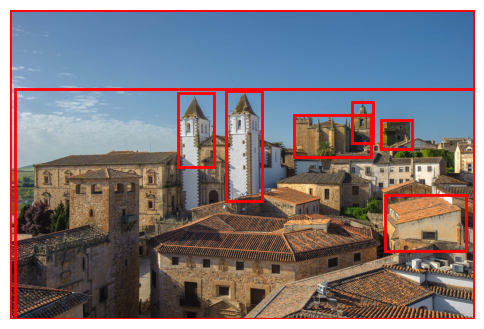

In [139]:
scaled_boxes, _, _ = postprocess.forward(boxes, [], [], orig_size)
show_bboxes(TEST_IMG_PATH, scaled_boxes)

In [140]:
boxes_out, scores_out, classes_out = searcher.forward(boxes, descriptors, places_db_cac)

print('boxes_out.shape: ', boxes_out.shape)
print('scores_out.shape: ', scores_out.shape)
print('classes_out.shape:', classes_out.shape)
print('orig_size:', orig_size)

boxes_out.shape:  torch.Size([1, 4])
scores_out.shape:  torch.Size([1])
classes_out.shape: torch.Size([1])
orig_size: tensor([2500., 1663.])


In [141]:
scaled_boxes, final_scores, final_classes = postprocess.forward(boxes_out, scores_out, classes_out, orig_size)

Encontradas 1 cajas:
  Clase 10 Iglesia de San Francisco Javier @ 0.83 → [900.4,437.6,1352.9,1029.0]


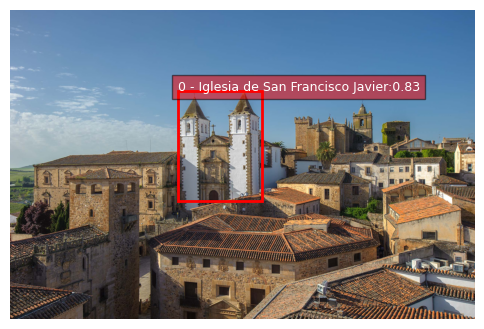

In [142]:
show_bboxes(TEST_IMG_PATH, scaled_boxes, CACERES_LANDMARK_NAMES_PATH, final_classes, final_scores)